In [1]:
import numpy as np
import pandas as pd
from gurobipy import Model, GRB, quicksum
from sklearn.metrics.pairwise import rbf_kernel
from ucimlrepo import fetch_ucirepo
import time

In [2]:
# ===================== COMMON UTILS =====================
import itertools
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

def quad_map(X: np.ndarray):
    """Homogeneous degree-2 explicit mapping building blocks: diag & cross & pairs."""
    m, n = X.shape
    Phi_diag = X ** 2
    pairs = list(itertools.combinations(range(n), 2))
    sqrt2 = np.sqrt(2.0)
    Phi_cross_list = [sqrt2 * (X[:, i] * X[:, j]) for (i, j) in pairs]
    return Phi_diag, Phi_cross_list, pairs

def decision_scores(w_diag, w_cross, b, Phi_diag, Phi_cross_list):
    """Compute f(x) on training set."""
    m = Phi_diag.shape[0]
    fx = b * np.ones(m)
    for j in range(len(w_diag)):
        fx += w_diag[j] * Phi_diag[:, j]
    for k in range(len(w_cross)):
        fx += w_cross[k] * Phi_cross_list[k]
    return fx

def hinge_loss(y, f):
    return np.maximum(0.0, 1.0 - y * f)

def count_support(y, f, tol=1e-8):
    return int(np.sum(1.0 - y * f > tol))

def _collect_gurobi_stats(model: gp.Model):
    """Safe get of Gurobi stats."""
    d = {}
    attrs = {
        "Status":"Status", "Runtime":"Runtime", "MIPGap":"MIPGap", "ObjVal":"ObjVal",
        "ObjBound":"ObjBound", "NodeCount":"NodeCount", "IterCount":"IterCount",
        "BarIterCount":"BarIterCount"
    }
    for k, attr in attrs.items():
        try:
            d[k] = getattr(model, attr)
        except Exception:
            d[k] = None
    d["time_limit_hit"] = (d["Status"] == GRB.TIME_LIMIT)
    return d

# ===================== BIG-M MODEL (v + z) =====================
class BigMNLSVMQuadPlus:
    """
    Big-M Nonlinear SVM with explicit quadratic features:
      - v_j ∈ {0,1} selects original feature j
      - z_{ij} = v_i AND v_j  (linearized)
      - |w_diag_j| ≤ M v_j ; |w_cross_ij| ≤ M z_ij
      - sum v = B
      - indicator mapping: diag x_j^2 ; cross sqrt(2)*x_i x_j
    Extra: rich metrics, warm-start, branch priority, custom gurobi params.
    """
    def __init__(self, X, y, feature_names=None,
                 big_m=10.0, time_limit=None, verbose=False,
                 gurobi_params: dict | None = None):
        self.X = X
        self.y = y.astype(float)
        self.m, self.n = X.shape
        self.feature_names = feature_names or [f"x{j+1}" for j in range(self.n)]
        self.M = float(big_m)
        self.time_limit = time_limit
        self.verbose = verbose
        self.Phi_diag, self.Phi_cross_list, self.pairs = quad_map(self.X)
        self.P = len(self.pairs)
        self._build_model(gurobi_params or {})

    def _build_model(self, gparams: dict):
        m, n, P, M = self.m, self.n, self.P, self.M
        y = self.y
        mdl = gp.Model("BigM-NLSVM-Quad+")
        # base params
        if not self.verbose:
            mdl.Params.OutputFlag = 0
        if self.time_limit is not None:
            mdl.Params.TimeLimit = self.time_limit
        # custom params
        for k, v in gparams.items():
            try:
                setattr(mdl.Params, k, v)
            except Exception:
                pass

        # vars
        self.w_diag  = mdl.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="w_sq")
        self.w_cross = mdl.addVars(P, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="w_cross")
        self.b = mdl.addVar(lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="b")
        self.xi = mdl.addVars(m, lb=0.0, vtype=GRB.CONTINUOUS, name="xi")
        self.v  = mdl.addVars(n, vtype=GRB.BINARY, name="v")     # original select
        self.z  = mdl.addVars(P, vtype=GRB.BINARY, name="z")     # cross enable

        # Big-M links
        for j in range(n):
            mdl.addConstr(self.w_diag[j] <= M * self.v[j], name=f"diag_pos_{j}")
            mdl.addConstr(-self.w_diag[j] <= M * self.v[j], name=f"diag_neg_{j}")
            # branch priority on v
            self.v[j].BranchPriority = 10

        for k, (i, j) in enumerate(self.pairs):
            mdl.addConstr(self.w_cross[k] <= M * self.z[k], name=f"cross_pos_{k}")
            mdl.addConstr(-self.w_cross[k] <= M * self.z[k], name=f"cross_neg_{k}")
            # AND (linearization)
            mdl.addConstr(self.z[k] <= self.v[i], name=f"z_le_vi_{k}")
            mdl.addConstr(self.z[k] <= self.v[j], name=f"z_le_vj_{k}")
            mdl.addConstr(self.z[k] >= self.v[i] + self.v[j] - 1, name=f"z_ge_sum_{k}")
            self.z[k].BranchPriority = 5

        # margin
        for i in range(m):
            expr = self.b
            for j in range(self.n):
                expr += self.w_diag[j] * float(self.Phi_diag[i, j])
            for k in range(self.P):
                expr += self.w_cross[k] * float(self.Phi_cross_list[k][i])
            mdl.addConstr(y[i] * expr >= 1.0 - self.xi[i], name=f"margin_{i}")

        # budget
        self.budget_con = mdl.addConstr(gp.quicksum(self.v[j] for j in range(self.n)) == self.n, name="sum_v_eq")

        # objective
        quad = gp.QuadExpr()
        for j in range(self.n):
            quad += self.w_diag[j] * self.w_diag[j]
        for k in range(self.P):
            quad += self.w_cross[k] * self.w_cross[k]
        self.C = 1.0
        mdl.setObjective(0.5 * quad + self.C * gp.quicksum(self.xi[i] for i in range(self.m)), GRB.MINIMIZE)
        self.model = mdl
        mdl.update()

    def set_B(self, B: int):
        self.budget_con.RHS = int(self.n - (self.n - B))  # i.e., = B
        self.model.update()

    def set_C(self, C: float):
        self.C = float(C)
        quad = gp.QuadExpr()
        for j in range(self.n):
            quad += self.w_diag[j] * self.w_diag[j]
        for k in range(self.P):
            quad += self.w_cross[k] * self.w_cross[k]
        self.model.setObjective(0.5 * quad + self.C * gp.quicksum(self.xi[i] for i in range(self.m)), GRB.MINIMIZE)
        self.model.update()

    def _warm_start_from_idx(self, selected_idx):
        # v: 1 if selected; here selected means enabled -> v=1
        for j in range(self.n):
            self.v[j].Start = 0
        for j in selected_idx:
            self.v[j].Start = 1
        # z start: v_i AND v_j
        for k, (i, j) in enumerate(self.pairs):
            self.z[k].Start = 1 if (i in selected_idx and j in selected_idx) else 0

    def optimize(self, eps_nnz: float = 1e-6):
        self.model.optimize()
        stats = _collect_gurobi_stats(self.model)

        sol = {
            "status": stats["Status"],
            "runtime": stats["Runtime"],
            "objval": stats["ObjVal"],
            "objbound": stats["ObjBound"],
            "gap": stats["MIPGap"],
            "nodes": stats["NodeCount"],
            "itcount": stats["IterCount"],
            "bariter": stats["BarIterCount"],
            "time_limit_hit": stats["time_limit_hit"],
            "selected_features": None,
            "nnz_w_diag": None,
            "nnz_w_cross": None,
            "n_cross_activated": None,
            "sum_xi": None,
            "n_support": None,
        }

        if self.model.SolCount > 0:
            # chosen original features (v_j=1)
            chosen_idx = [j for j in range(self.n) if self.v[j].X > 0.5]
            sol["selected_features"] = [self.feature_names[j] for j in chosen_idx]

            # weights/metrics
            w_diag = np.array([self.w_diag[j].X for j in range(self.n)])
            w_cross = np.array([self.w_cross[k].X for k in range(self.P)])
            b = self.b.X
            xi = np.array([self.xi[i].X for i in range(self.m)])

            sol["nnz_w_diag"] = int(np.sum(np.abs(w_diag) > eps_nnz))
            sol["nnz_w_cross"] = int(np.sum(np.abs(w_cross) > eps_nnz))
            # activated cross (z=1 and |w_cross|>eps)
            z_on = np.array([self.z[k].X for k in range(self.P)]) > 0.5
            sol["n_cross_activated"] = int(np.sum(z_on & (np.abs(w_cross) > eps_nnz)))

            f = decision_scores(w_diag, w_cross, b, self.Phi_diag, self.Phi_cross_list)
            sol["sum_xi"] = float(np.sum(xi))
            sol["n_support"] = count_support(self.y, f)

        return sol

    def run_grid(self, C_values, B_values=None, eps_nnz: float = 1e-6,
                 warm_start: bool = True, prev_selected: list[int] | None = None):
        if B_values is None:
            B_values = list(range(1, self.n + 1))
        records = []
        prev = prev_selected or []
        for B in B_values:
            self.set_B(B)
            best = None
            # warm start from previous B (greedy carry-over)
            if warm_start and len(prev) > 0:
                # if prev has >B, keep first B; if <B, keep all and solver will add
                self._warm_start_from_idx(prev[:B])
            for C in C_values:
                self.set_C(C)
                r = self.optimize(eps_nnz=eps_nnz)
                r.update({"B": B, "C": C})
                records.append(r)
                if r["objval"] is not None and (best is None or r["objval"] < best["objval"]):
                    best = r
            if self.verbose and best is not None:
                print(f"[BigM Best @ B={B}] C={best['C']} obj={best['objval']:.6g} "
                      f"time={best['runtime']:.2f}s gap={best['gap']:.4g} "
                      f"features={best['selected_features']}")
            # carry best selection to next B
            if best and best["selected_features"]:
                # map back to indices
                name2idx = {n:i for i,n in enumerate(self.feature_names)}
                prev = [name2idx[nm] for nm in best["selected_features"]]
        return {"records": records}

# ===================== INDICATOR MODEL (CoP, no Big-M) =====================
class CoNLSVMQuad_NoMPlus:
    """
    Co-NLSVM (no Big-M) with indicator constraints:
      - t_j ∈ {0,1}, sum t = n - B
      - t_j=1 ⇒ w_diag_j = 0
      - t_i=1 or t_j=1 ⇒ w_cross_ij = 0
    Extra: rich metrics, warm-start, branch priority, custom params.
    """
    def __init__(self, X, y, feature_names=None,
                 time_limit=None, verbose=False,
                 gurobi_params: dict | None = None):
        self.X = X
        self.y = y.astype(float)
        self.m, self.n = X.shape
        self.feature_names = feature_names or [f"x{j+1}" for j in range(self.n)]
        self.time_limit = time_limit
        self.verbose = verbose
        self.Phi_diag, self.Phi_cross_list, self.pairs = quad_map(self.X)
        self.P = len(self.pairs)
        self._build_model(gurobi_params or {})

    def _build_model(self, gparams: dict):
        m, n, P = self.m, self.n, self.P
        y = self.y
        mdl = gp.Model("Co-NLSVM-Quad-NoM+")
        if not self.verbose:
            mdl.Params.OutputFlag = 0
        if self.time_limit is not None:
            mdl.Params.TimeLimit = self.time_limit
        for k, v in gparams.items():
            try:
                setattr(mdl.Params, k, v)
            except Exception:
                pass

        self.w_diag  = mdl.addVars(n, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="w_sq")
        self.w_cross = mdl.addVars(P, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="w_cross")
        self.b = mdl.addVar(lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="b")
        self.xi = mdl.addVars(m, lb=0.0, vtype=GRB.CONTINUOUS, name="xi")
        self.t  = mdl.addVars(n, vtype=GRB.BINARY, name="t")  # 1 = disabled
        for j in range(n):
            # priority on t
            self.t[j].BranchPriority = 10
            # t_j=1 ⇒ w_diag_j=0
            mdl.addGenConstrIndicator(self.t[j], 1, self.w_diag[j], GRB.LESS_EQUAL, 0.0, name=f"diag_le0_{j}")
            mdl.addGenConstrIndicator(self.t[j], 1, -self.w_diag[j], GRB.LESS_EQUAL, 0.0, name=f"diag_ge0_{j}")

        for k, (i, j) in enumerate(self.pairs):
            # if either end disabled ⇒ w_cross=0
            mdl.addGenConstrIndicator(self.t[i], 1, self.w_cross[k], GRB.LESS_EQUAL, 0.0, name=f"cross_i_le0_{k}")
            mdl.addGenConstrIndicator(self.t[i], 1, -self.w_cross[k], GRB.LESS_EQUAL, 0.0, name=f"cross_i_ge0_{k}")
            mdl.addGenConstrIndicator(self.t[j], 1, self.w_cross[k], GRB.LESS_EQUAL, 0.0, name=f"cross_j_le0_{k}")
            mdl.addGenConstrIndicator(self.t[j], 1, -self.w_cross[k], GRB.LESS_EQUAL, 0.0, name=f"cross_j_ge0_{k}")

        # margin
        for i in range(m):
            expr = self.b
            for j in range(self.n):
                expr += self.w_diag[j] * float(self.Phi_diag[i, j])
            for k in range(self.P):
                expr += self.w_cross[k] * float(self.Phi_cross_list[k][i])
            mdl.addConstr(y[i] * expr >= 1.0 - self.xi[i], name=f"margin_{i}")

        # budget: sum t = n - B  (set later)
        self.budget_con = mdl.addConstr(gp.quicksum(self.t[j] for j in range(self.n)) == self.n, name="sum_t_eq")

        # objective
        quad = gp.QuadExpr()
        for j in range(self.n):
            quad += self.w_diag[j] * self.w_diag[j]
        for k in range(self.P):
            quad += self.w_cross[k] * self.w_cross[k]
        self.C = 1.0
        mdl.setObjective(0.5 * quad + self.C * gp.quicksum(self.xi[i] for i in range(self.m)), GRB.MINIMIZE)
        self.model = mdl
        mdl.update()

    def set_B(self, B: int):
        self.budget_con.RHS = int(self.n - B)
        self.model.update()

    def set_C(self, C: float):
        self.C = float(C)
        quad = gp.QuadExpr()
        for j in range(self.n):
            quad += self.w_diag[j] * self.w_diag[j]
        for k in range(self.P):
            quad += self.w_cross[k] * self.w_cross[k]
        self.model.setObjective(0.5 * quad + self.C * gp.quicksum(self.xi[i] for i in range(self.m)), GRB.MINIMIZE)
        self.model.update()

    def _warm_start_from_idx(self, selected_idx):
        # t: 0 if selected, 1 otherwise
        for j in range(self.n):
            self.t[j].Start = 1
        for j in selected_idx:
            self.t[j].Start = 0

    def optimize(self, eps_nnz: float = 1e-6):
        self.model.optimize()
        stats = _collect_gurobi_stats(self.model)
        sol = {
            "status": stats["Status"],
            "runtime": stats["Runtime"],
            "objval": stats["ObjVal"],
            "objbound": stats["ObjBound"],
            "gap": stats["MIPGap"],
            "nodes": stats["NodeCount"],
            "itcount": stats["IterCount"],
            "bariter": stats["BarIterCount"],
            "time_limit_hit": stats["time_limit_hit"],
            "selected_features": None,
            "nnz_w_diag": None,
            "nnz_w_cross": None,
            "n_cross_activated": None,
            "sum_xi": None,
            "n_support": None,
        }
        if self.model.SolCount > 0:
            chosen_idx = [j for j in range(self.n) if self.t[j].X < 0.5]  # t=0 selected
            sol["selected_features"] = [self.feature_names[j] for j in chosen_idx]

            w_diag = np.array([self.w_diag[j].X for j in range(self.n)])
            w_cross = np.array([self.w_cross[k].X for k in range(self.P)])
            b = self.b.X
            xi = np.array([self.xi[i].X for i in range(self.m)])
            sol["nnz_w_diag"] = int(np.sum(np.abs(w_diag) > eps_nnz))
            sol["nnz_w_cross"] = int(np.sum(np.abs(w_cross) > eps_nnz))
            # activated cross: both ends selected & |w_cross|>eps
            active_pairs = 0
            chosen_set = set(chosen_idx)
            for k, (i, j) in enumerate(self.pairs):
                if (i in chosen_set and j in chosen_set) and abs(w_cross[k]) > eps_nnz:
                    active_pairs += 1
            sol["n_cross_activated"] = int(active_pairs)

            f = decision_scores(w_diag, w_cross, b, self.Phi_diag, self.Phi_cross_list)
            sol["sum_xi"] = float(np.sum(xi))
            sol["n_support"] = count_support(self.y, f)

        return sol

    def run_grid(self, C_values, B_values=None, eps_nnz: float = 1e-6,
                 warm_start: bool = True, prev_selected: list[int] | None = None):
        if B_values is None:
            B_values = list(range(1, self.n + 1))
        records = []
        prev = prev_selected or []
        for B in B_values:
            self.set_B(B)
            if warm_start and len(prev) > 0:
                self._warm_start_from_idx(prev[:B])
            best = None
            for C in C_values:
                self.set_C(C)
                r = self.optimize(eps_nnz=eps_nnz)
                r.update({"B": B, "C": C})
                records.append(r)
                if r["objval"] is not None and (best is None or r["objval"] < best["objval"]):
                    best = r
            if self.verbose and best is not None:
                print(f"[CoP Best @ B={B}] C={best['C']} obj={best['objval']:.6g} "
                      f"time={best['runtime']:.2f}s gap={best['gap']:.4g} "
                      f"features={best['selected_features']}")
            if best and best["selected_features"]:
                name2idx = {n:i for i,n in enumerate(self.feature_names)}
                prev = [name2idx[nm] for nm in best["selected_features"]]
        return {"records": records}

# ===================== COMPARISON HELPERS =====================
def compare_records(records_bigm: list[dict], records_cop: list[dict]):
    df_b = pd.DataFrame(records_bigm).copy()
    df_b["model"] = "Big-M"
    df_c = pd.DataFrame(records_cop).copy()
    df_c["model"] = "CoP"
    df_all = pd.concat([df_b, df_c], ignore_index=True)

    # per-B best rows (by objval)
    best_b = df_b.sort_values(["B","objval"]).groupby("B", as_index=False).first()
    best_c = df_c.sort_values(["B","objval"]).groupby("B", as_index=False).first()

    # speedup & jaccard
    rows = []
    for _, rb in best_b.iterrows():
        B = int(rb["B"])
        rc = best_c[best_c["B"]==B]
        if rc.empty: 
            continue
        rc = rc.iloc[0]
        tb, tc = rb["runtime"], rc["runtime"]
        speed = (tb / tc) if (tc and tc>0) else np.nan
        # jaccard
        fa = set(rb.get("selected_features", []) or [])
        fb = set(rc.get("selected_features", []) or [])
        jacc = len(fa & fb) / len(fa | fb) if len(fa | fb) > 0 else np.nan
        rows.append({
            "B": B,
            "obj_BigM": rb["objval"], "gap_BigM": rb["gap"], "time_BigM": rb["runtime"],
            "obj_CoP": rc["objval"],  "gap_CoP": rc["gap"],  "time_CoP": rc["runtime"],
            "speedup_BigM_over_CoP": speed,
            "jaccard_features": jacc,
            "sel_BigM": rb.get("selected_features", None),
            "sel_CoP": rc.get("selected_features", None),
            "nodes_BigM": rb.get("nodes", None), "nodes_CoP": rc.get("nodes", None),
            "support_BigM": rb.get("n_support", None), "support_CoP": rc.get("n_support", None),
            "sumxi_BigM": rb.get("sum_xi", None), "sumxi_CoP": rc.get("sum_xi", None),
            "nnz_diag_BigM": rb.get("nnz_w_diag", None), "nnz_diag_CoP": rc.get("nnz_w_diag", None),
            "nnz_cross_BigM": rb.get("nnz_w_cross", None), "nnz_cross_CoP": rc.get("nnz_w_cross", None),
            "n_cross_act_BigM": rb.get("n_cross_activated", None),
            "n_cross_act_CoP": rc.get("n_cross_activated", None),
        })
    summary = pd.DataFrame(rows)
    return df_all, summary


# ===================== CV SCHEDULER & METRICS =====================
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

def _score_on(X, pairs, w_diag, w_cross, b):
    """
    f(x) = b + Σ_j w_diag_j * x_j^2 + Σ_{i<j} w_cross_k * sqrt(2) * x_i * x_j
    pairs 与 w_cross 的顺序一致（由模型内部 pairs 提供）。
    """
    X2 = X * X
    f = b + X2 @ w_diag
    # 交叉项
    import numpy as np
    sqrt2 = np.sqrt(2.0)
    for k, (i, j) in enumerate(pairs):
        f += w_cross[k] * (sqrt2 * X[:, i] * X[:, j])
    return f

def _extract_solution_from_solver(solver, eps_nnz=1e-9):
    """从已优化的 solver 实例中取 w_diag, w_cross, b, 以及选择的原始特征索引。"""
    import numpy as np
    w_diag = np.array([solver.w_diag[j].X for j in range(solver.n)])
    w_cross = np.array([solver.w_cross[k].X for k in range(solver.P)])
    b = solver.b.X
    # 选中的原始特征（两类模型变量名不同）
    if hasattr(solver, "v"):
        chosen_idx = [j for j in range(solver.n) if solver.v[j].X > 0.5]
    else:
        chosen_idx = [j for j in range(solver.n) if solver.t[j].X < 0.5]
    return w_diag, w_cross, b, chosen_idx

def cv_grid_search_model(
    model_name: str,
    model_cls,                 # BigMNLSVMQuadPlus 或 CoNLSVMQuad_NoMPlus
    X: np.ndarray,
    y: np.ndarray,             # {-1,+1}
    feature_names: list[str],
    B_grid: list[int],
    C_grid: list[float],
    n_splits: int = 5,
    time_limit: float | None = 180.0,
    gurobi_params: dict | None = None,
    warm_start: bool = True,
    random_state: int = 0,
    global_time_budget: float | None = None,  # ☆ 整个模型（所有折×B×C）的总时长预算（秒）
    progress: bool = True,                    # ☆ 打印进度
    auto_flip_auc: bool = True,               # ☆ 若 -f 的 AUC 更大，则采用翻转后的 AUC
):
    """
    返回：
      df  : 每个 (fold,B,C) 一行的明细
      agg : 按 (model,B,C) 聚合的均值/方差（用于热力图/最佳C挑选）
    说明：
      - 每个 (fold,B,C) 的单次 Gurobi 求解仍由 time_limit 控制；
      - global_time_budget 控制整个模型（Big-M 或 CoP）的总时间，触达即提前返回已有结果。
    """
    start_all = time.monotonic()
    total_jobs = n_splits * len(B_grid) * len(C_grid)
    done = 0

    records = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # 为了计算 AUC，准备 {0,1} 标签
    y01_all = (y == 1).astype(int)

    # 便捷：将 NaN 视作非常小/大，便于排序
    def _nan_to(val, low=-np.inf):
        return val if (val == val) else low

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y01_all), start=1):
        X_tr_raw, X_va_raw = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]
        y01_va = y01_all[va_idx]

        # 每个fold单独标准化（避免信息泄露）
        scaler = StandardScaler().fit(X_tr_raw)
        X_tr = scaler.transform(X_tr_raw)
        X_va = scaler.transform(X_va_raw)

        # 实例化模型（构建特征映射）；二者接口略有差异
        if model_name.lower().startswith("big"):
            solver = model_cls(
                X_tr, y_tr, feature_names=feature_names,
                big_m=10.0, time_limit=time_limit, verbose=False,
                gurobi_params=gurobi_params or {}
            )
            select_var = "v"
        else:
            solver = model_cls(
                X_tr, y_tr, feature_names=feature_names,
                time_limit=time_limit, verbose=False,
                gurobi_params=gurobi_params or {}
            )
            select_var = "t"

        prev_selected = []  # warm-start：上一轮 B 的已选索引

        for B in B_grid:
            solver.set_B(B)

            # warm-start 到选特征变量
            if warm_start and prev_selected:
                if select_var == "v":
                    for j in range(solver.n): solver.v[j].Start = 0
                    for j in prev_selected[:B]: solver.v[j].Start = 1
                    # 同步 z 的启发式起点（可选）
                    if hasattr(solver, "z"):
                        for k, (i, j2) in enumerate(solver.pairs):
                            solver.z[k].Start = 1 if (i in prev_selected and j2 in prev_selected) else 0
                else:
                    for j in range(solver.n): solver.t[j].Start = 1
                    for j in prev_selected[:B]: solver.t[j].Start = 0

            # 在该 B 下遍历 C
            for C in C_grid:
                # ☆ 全局时间预算：每个 (B,C) 前检查一次
                if global_time_budget is not None:
                    elapsed = time.monotonic() - start_all
                    if elapsed >= global_time_budget:
                        if progress:
                            print(f"[{model_name}] Global time budget exceeded "
                                  f"({elapsed:.1f}s ≥ {global_time_budget}s). Returning partial results.")
                        # 提前返回已有结果
                        df_partial = pd.DataFrame(records)
                        if df_partial.empty:
                            # 返回空框架，调用端自己判断
                            return df_partial, df_partial
                        agg_partial = (
                            df_partial.groupby(["model","B","C"], as_index=False)
                            .agg(val_auc_mean=("val_auc","mean"),
                                 val_auc_std =("val_auc","std"),
                                 val_acc_mean=("val_acc","mean"),
                                 val_acc_std =("val_acc","std"),
                                 val_bacc_mean=("val_bacc","mean"),
                                 train_time_mean=("train_time","mean"),
                                 train_gap_mean =("train_gap","mean"),
                                 nodes_mean     =("nodes","mean"),
                                 timeouts       =("time_limit_hit","sum"),
                                 nnz_diag_mean  =("nnz_w_diag","mean"),
                                 nnz_cross_mean =("nnz_w_cross","mean"),
                                 n_cross_act_mean=("n_cross_activated","mean"))
                        )
                        return df_partial, agg_partial

                solver.set_C(C)
                sol = solver.optimize(eps_nnz=1e-6)  # 已封装：返回 obj/gap/time 等

                # 取权重并在验证集上打分
                if solver.model.SolCount > 0:
                    w_diag, w_cross, b, chosen_idx = _extract_solution_from_solver(solver)
                    f_va = _score_on(X_va, solver.pairs, w_diag, w_cross, b)
                    y_hat_va = np.sign(f_va)

                    # 分类指标
                    acc = accuracy_score(y_va, y_hat_va)
                    # 若验证折只有一个类别，bacc/AUC 置 NaN
                    has_two_classes = (np.unique(y_va).size == 2)
                    bacc = balanced_accuracy_score(y_va, y_hat_va) if has_two_classes else np.nan

                    # AUC：用原分数与翻转分数择优（可关闭）
                    if has_two_classes:
                        try:
                            auc_raw = roc_auc_score(y01_va, f_va)
                            if auto_flip_auc:
                                auc_flip = roc_auc_score(y01_va, -f_va)
                                auc = max(auc_raw, auc_flip)
                            else:
                                auc = auc_raw
                        except Exception:
                            auc = np.nan
                    else:
                        auc = np.nan
                else:
                    acc = bacc = auc = np.nan
                    chosen_idx = []

                rec = {
                    "model": model_name,
                    "fold": fold,
                    "B": B,
                    "C": C,
                    "val_acc": acc,
                    "val_bacc": bacc,
                    "val_auc": auc,
                    # 训练端的一些解信息（来自 sol 字典）
                    "train_obj": sol.get("objval", np.nan),
                    "train_gap": sol.get("gap", np.nan),
                    "train_time": sol.get("runtime", np.nan),
                    "nodes": sol.get("nodes", np.nan),
                    "time_limit_hit": sol.get("time_limit_hit", False),
                    "sum_xi": sol.get("sum_xi", np.nan),
                    "n_support": sol.get("n_support", np.nan),
                    "nnz_w_diag": sol.get("nnz_w_diag", np.nan),
                    "nnz_w_cross": sol.get("nnz_w_cross", np.nan),
                    "n_cross_activated": sol.get("n_cross_activated", np.nan),
                    "selected_features": [feature_names[j] for j in chosen_idx] if chosen_idx else [],
                }
                records.append(rec)

                # ☆ 进度
                done += 1
                if progress:
                    elapsed = time.monotonic() - start_all
                    print(f"[{model_name}] progress: {done}/{total_jobs}  "
                          f"(fold={fold}, B={B}, C={C})  elapsed={elapsed:.1f}s")

            # 更新 warm-start 的 prev_selected（用该 B 内 AUC 最好的那条；再看 acc，再看更小 train_time）
            if warm_start:
                candB = [r for r in records if r["model"]==model_name and r["fold"]==fold and r["B"]==B]
                if candB:
                    candB_sorted = sorted(
                        candB,
                        key=lambda d: (-_nan_to(d["val_auc"]), -_nan_to(d["val_acc"]), _nan_to(d["train_time"], low=np.inf))
                    )
                    bestB = candB_sorted[0]
                    name2idx = {n:i for i,n in enumerate(feature_names)}
                    prev_selected = [name2idx[nm] for nm in (bestB["selected_features"] or [])]

    # 全部完成后的聚合
    df = pd.DataFrame(records)
    agg = (
        df.groupby(["model","B","C"], as_index=False)
          .agg(val_auc_mean=("val_auc","mean"),
               val_auc_std =("val_auc","std"),
               val_acc_mean=("val_acc","mean"),
               val_acc_std =("val_acc","std"),
               val_bacc_mean=("val_bacc","mean"),
               train_time_mean=("train_time","mean"),
               train_gap_mean =("train_gap","mean"),
               nodes_mean     =("nodes","mean"),
               timeouts       =("time_limit_hit","sum"),
               nnz_diag_mean  =("nnz_w_diag","mean"),
               nnz_cross_mean =("nnz_w_cross","mean"),
               n_cross_act_mean=("n_cross_activated","mean"))
    )
    return df, agg

def pick_best_per_B(agg: pd.DataFrame, primary="val_auc_mean", secondary="val_acc_mean"):
    """对每个 (model, B) 选出最佳 C（按 primary 再 secondary，最后按 train_time_mean 最小），返回一张 summary 表。"""
    rows = []
    for (model, B), grp in agg.groupby(["model","B"]):
        grp = grp.copy()
        grp = grp.sort_values(
            by=[primary, secondary, "train_time_mean"],
            ascending=[False, False, True]
        )
        best = grp.iloc[0]
        rows.append(best.to_dict())
    summary = pd.DataFrame(rows).sort_values(["model","B"]).reset_index(drop=True)
    return summary

def merge_model_summaries(sum_bigm, sum_cop):
    sb = sum_bigm.copy(); sb["which"] = "Big-M"
    sc = sum_cop.copy();  sc["which"] = "CoP"
    keep = ["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean",
            "nnz_diag_mean","nnz_cross_mean","n_cross_act_mean"]
    sb = sb[keep]; sc = sc[keep]
    merged = sb.merge(sc, on="B", suffixes=("_BigM","_CoP"))   # ★ 只按 B 合并
    merged["speedup_BigM_over_CoP"]     = merged["train_time_mean_BigM"] / merged["train_time_mean_CoP"]
    merged["delta_auc_CoP_minus_BigM"]  = merged["val_auc_mean_CoP"] - merged["val_auc_mean_BigM"]
    merged["delta_acc_CoP_minus_BigM"]  = merged["val_acc_mean_CoP"] - merged["val_acc_mean_BigM"]
    return merged

import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(agg: pd.DataFrame, model_name: str, metric="val_auc_mean", title=None, savepath=None):
    sub = agg[agg["model"]==model_name]
    # pivot: rows=C, cols=B
    pv = sub.pivot(index="C", columns="B", values=metric).sort_index()
    plt.figure()
    plt.imshow(pv, aspect="auto")
    plt.colorbar(label=metric)
    plt.xticks(range(len(pv.columns)), pv.columns)
    plt.yticks(range(len(pv.index)), pv.index)
    plt.xlabel("B (enabled original features)")
    plt.ylabel("C")
    plt.title(title or f"{model_name}: {metric} heatmap")
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_best_curve(summary: pd.DataFrame, label: str, metric="val_auc_mean", savepath=None):
    sub = summary.sort_values("B")
    plt.figure()
    plt.plot(sub["B"], sub[metric], marker="o", label=label)
    plt.xlabel("B")
    plt.ylabel(metric)
    plt.title(f"Best-per-B {metric}")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_runtime_box(df_cv: pd.DataFrame, savepath=None):
    """按模型与 B 展示训练时间分布（所有 C & 所有 folds）。"""
    plt.figure()
    # 构造每个 (model,B) 的箱线图数据
    labels, data = [], []
    for (model, B), grp in df_cv.groupby(["model","B"]):
        labels.append(f"{model}\nB={B}")
        data.append(grp["train_time"])
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("Train time (s)")
    plt.title("Train time distribution across folds & Cs")
    plt.xticks(rotation=45)
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

def plot_speedup_bar(merged_summary: pd.DataFrame, savepath=None):
    plt.figure()
    dd = merged_summary.sort_values("B")
    plt.bar(dd["B"].astype(str), dd["speedup_BigM_over_CoP"])
    plt.xlabel("B")
    plt.ylabel("Speedup (Big-M / CoP)")
    plt.title("Speedup (>1 means CoP faster)")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    if savepath:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()

样本数量: 683, 特征数量: 9
y 分布： {np.float64(-1.0): np.int64(239), np.float64(1.0): np.int64(444)}

=== Best-per-B (Big-M) ===
 B      C  val_auc_mean  val_acc_mean  train_time_mean  train_gap_mean
 1 100.00      0.736790      0.865318           0.1388        0.000000
 2   1.00      0.919036      0.925333           3.2056        0.000003
 3 100.00      0.934592      0.931204           1.9606        0.000019
 4   1.00      0.957376      0.942883           2.8340        0.000024
 5   0.10      0.963933      0.950182           2.3970        0.000009
 6   0.01      0.960748      0.942883           2.3838        0.000016
 7   0.01      0.960711      0.939953           1.8762        0.000041
 8   0.10      0.966603      0.947252           1.3630        0.000013
 9   0.10      0.964861      0.944322           0.1414        0.000000

=== Best-per-B (CoP) ===
 B      C  val_auc_mean  val_acc_mean  train_time_mean  train_gap_mean
 1 100.00      0.736790      0.865318           0.1060             0.0
 2 

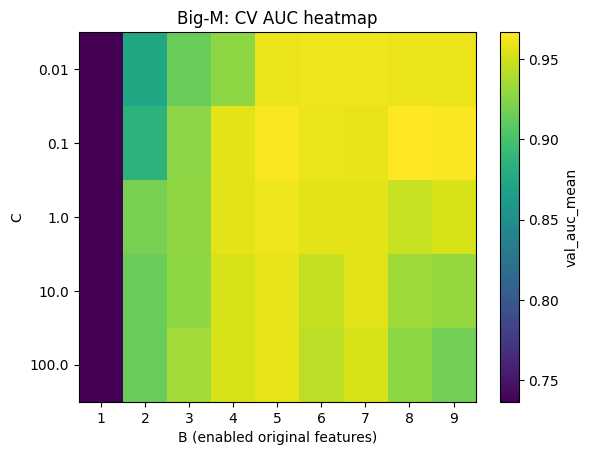

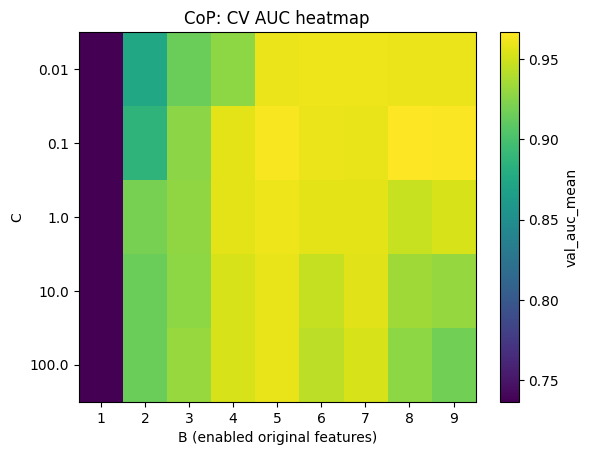

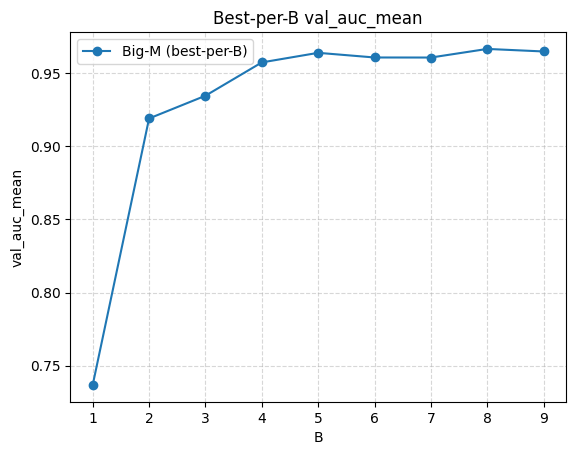

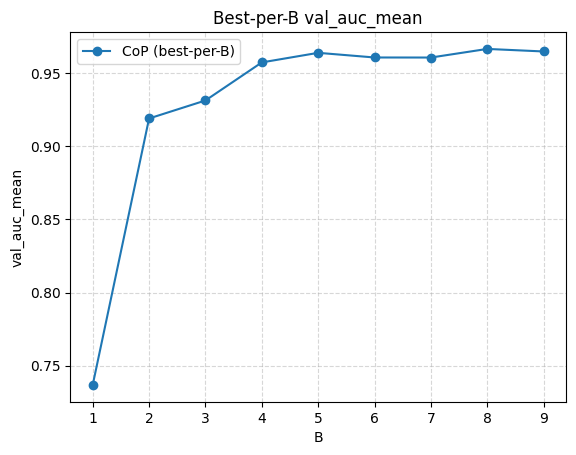

C:\Users\Snoopy\AppData\Local\Temp\ipykernel_47672\901617840.py:687: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


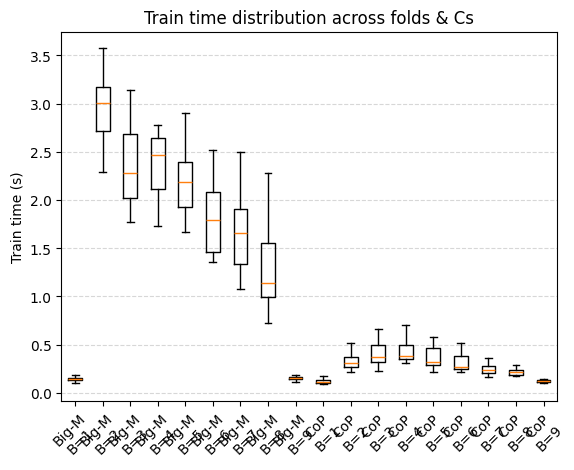

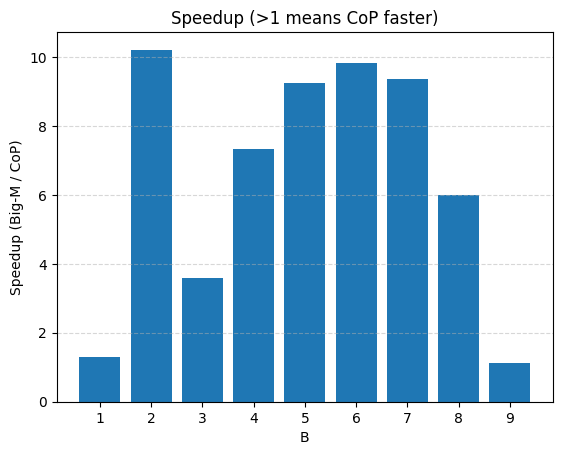

In [19]:
# 读取 UCI 数据
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

X_df = breast_cancer_wisconsin_original.data.features
y_series = breast_cancer_wisconsin_original.data.targets['Class']

# 清洗与对齐
X_df = X_df.replace('?', np.nan).dropna()
y_series = y_series.loc[X_df.index]

feature_names = list(X_df.columns)
X_raw = X_df.values  # 不在这里标准化，让 CV 内处理

# 正确的标签编码（2/4 是整数）
y_int = pd.to_numeric(y_series, errors='raise').values
uniq = np.unique(y_int)
assert set(uniq) == {2, 4}, f"意外的类别：{uniq}"
y = np.where(y_int == 2, 1.0, -1.0)  # 2=+1, 4=-1

print(f"样本数量: {X_raw.shape[0]}, 特征数量: {X_raw.shape[1]}")
print("y 分布：", dict(zip(*np.unique(y, return_counts=True))))

# 网格
B_grid = list(range(1, min(X_raw.shape[1], 10)+1))
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
gparams = dict(Seed=0, Heuristics=0.2, ConcurrentMIP=1)
K = 5

# 跑 CV（传原始 X；cv_grid 会自己做标准化）
df_bigm, agg_bigm = cv_grid_search_model(
    "Big-M", BigMNLSVMQuadPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=180.0, gurobi_params=gparams, warm_start=True, random_state=0
)

df_cop, agg_cop = cv_grid_search_model(
    "CoP", CoNLSVMQuad_NoMPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=180.0, gurobi_params=gparams, warm_start=True, random_state=0
)

# 合并挑最优（注意：修过的 merge_model_summaries 只按 B 合并）
agg_all = pd.concat([agg_bigm, agg_cop], ignore_index=True)
sum_bigm = pick_best_per_B(agg_all[agg_all["model"]=="Big-M"])
sum_cop  = pick_best_per_B(agg_all[agg_all["model"]=="CoP"])
merged   = merge_model_summaries(sum_bigm, sum_cop)

print("\n=== Best-per-B (Big-M) ===")
print(sum_bigm[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Best-per-B (CoP) ===")
print(sum_cop[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Big-M vs CoP (per-B) ===")
print(merged[["B","speedup_BigM_over_CoP","delta_auc_CoP_minus_BigM","delta_acc_CoP_minus_BigM",
              "train_time_mean_BigM","train_time_mean_CoP"]].to_string(index=False))

# 可视化
# --- 画图 ---
plot_heatmap(agg_all, "Big-M", metric="val_auc_mean", title="Big-M: CV AUC heatmap")
plot_heatmap(agg_all, "CoP",   metric="val_auc_mean", title="CoP: CV AUC heatmap")

plot_best_curve(sum_bigm, label="Big-M (best-per-B)", metric="val_auc_mean")
plot_best_curve(sum_cop,  label="CoP (best-per-B)",   metric="val_auc_mean")

plot_runtime_box(pd.concat([df_bigm, df_cop], ignore_index=True))

plot_speedup_bar(merged)


In [3]:
# fetch dataset 
wholesale_customers = fetch_ucirepo(id=292) 
# data (as pandas dataframes) 
X_wh = wholesale_customers.data.features 
y_wh = wholesale_customers.data.targets
print(f"样本数量: {X_wh.shape[0]}")
print(f"特征数量: {X_wh.shape[1]}")
print(y_wh.value_counts())

样本数量: 440
特征数量: 7
Region
3         316
1          77
2          47
Name: count, dtype: int64


样本数量: 440, 特征数量: 7
y 分布： {np.float64(-1.0): np.int64(316), np.float64(1.0): np.int64(124)}

=== Best-per-B (Big-M) ===
 B    C  val_auc_mean  val_acc_mean  train_time_mean  train_gap_mean
 1 1.00      0.492571      0.718182           0.0476    3.824704e-05
 2 0.01      0.473212      0.718182           1.3220    5.758290e-07
 3 0.01      0.474943      0.718182           1.5820    1.072711e-05
 4 0.10      0.477283      0.715909           1.4264    1.094005e-05
 5 0.10      0.473756      0.718182           1.3804    1.193826e-05
 6 0.01      0.453760      0.718182           0.9162    1.423763e-05
 7 0.01      0.449160      0.718182           0.1056    0.000000e+00

=== Best-per-B (CoP) ===
 B    C  val_auc_mean  val_acc_mean  train_time_mean  train_gap_mean
 1 0.01      0.492571      0.718182           0.0596    0.000000e+00
 2 0.01      0.473212      0.718182           0.2584    0.000000e+00
 3 0.01      0.475070      0.718182           0.2940    0.000000e+00
 4 0.10      0.477156      

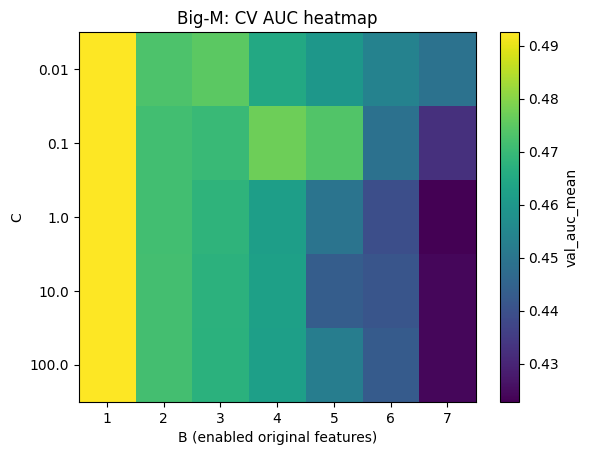

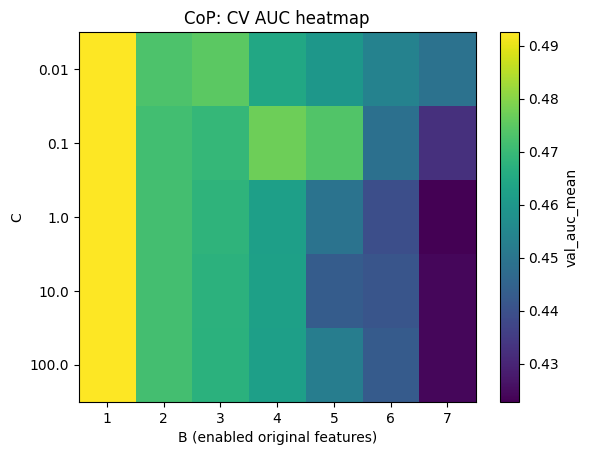

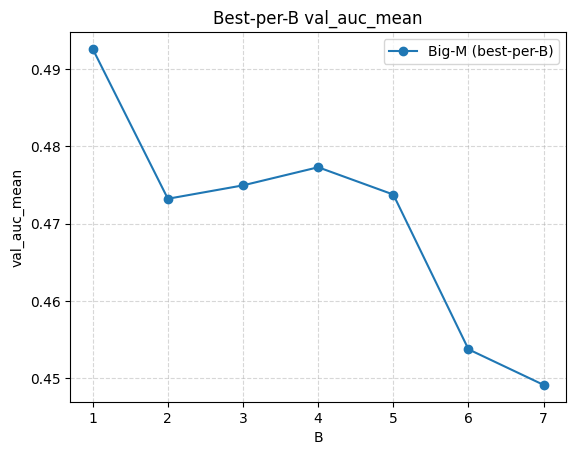

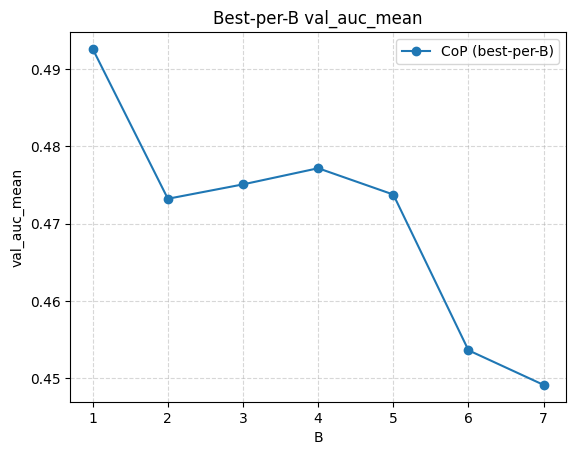

C:\Users\Snoopy\AppData\Local\Temp\ipykernel_15664\901617840.py:687: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


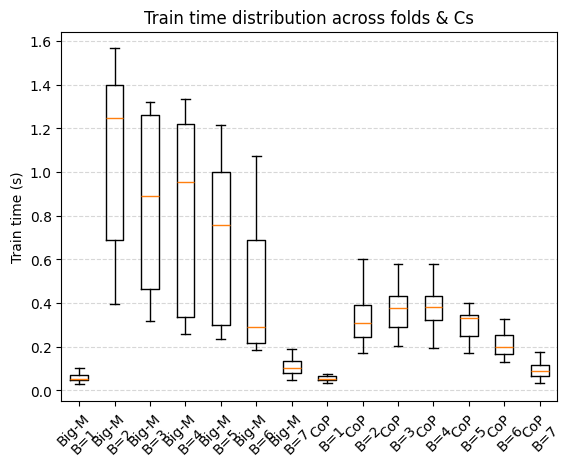

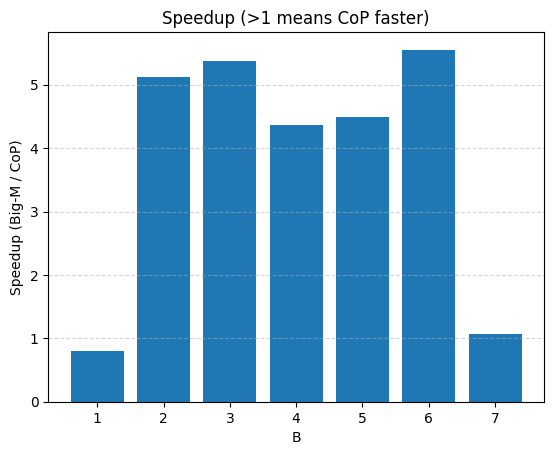

In [ ]:
# 读取 UCI 数据
wholesale_customers = fetch_ucirepo(id=292) 

X_df = wholesale_customers.data.features
y_series = wholesale_customers.data.targets['Region']

# 清洗与对齐
X_df = X_df.replace('?', np.nan).dropna()
y_series = y_series.loc[X_df.index]

feature_names = list(X_df.columns)
X_raw = X_df.values  # 不在这里标准化，让 CV 内处理

# 正确的标签编码
y_int = pd.to_numeric(y_series, errors='raise').values
y = np.where(y_int == 3, 1.0, -1.0)  # 3=1, 1，2=-1

print(f"样本数量: {X_raw.shape[0]}, 特征数量: {X_raw.shape[1]}")
print("y 分布：", dict(zip(*np.unique(y, return_counts=True))))

# 网格
B_grid = list(range(1, 8))
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
gparams = dict(Seed=0, Heuristics=0.2, ConcurrentMIP=1)
K = 5

# 跑 CV（传原始 X；cv_grid 会自己做标准化）
df_bigm, agg_bigm = cv_grid_search_model(
    "Big-M", BigMNLSVMQuadPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=180.0, gurobi_params=gparams, warm_start=True, random_state=0
)

df_cop, agg_cop = cv_grid_search_model(
    "CoP", CoNLSVMQuad_NoMPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=180.0, gurobi_params=gparams, warm_start=True, random_state=0
)

# 合并挑最优（注意：修过的 merge_model_summaries 只按 B 合并）
agg_all = pd.concat([agg_bigm, agg_cop], ignore_index=True)
sum_bigm = pick_best_per_B(agg_all[agg_all["model"]=="Big-M"])
sum_cop  = pick_best_per_B(agg_all[agg_all["model"]=="CoP"])
merged   = merge_model_summaries(sum_bigm, sum_cop)

print("\n=== Best-per-B (Big-M) ===")
print(sum_bigm[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Best-per-B (CoP) ===")
print(sum_cop[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Big-M vs CoP (per-B) ===")
print(merged[["B","speedup_BigM_over_CoP","delta_auc_CoP_minus_BigM","delta_acc_CoP_minus_BigM",
              "train_time_mean_BigM","train_time_mean_CoP"]].to_string(index=False))

# 可视化
# --- 画图 ---
plot_heatmap(agg_all, "Big-M", metric="val_auc_mean", title="Big-M: CV AUC heatmap")
plot_heatmap(agg_all, "CoP",   metric="val_auc_mean", title="CoP: CV AUC heatmap")

plot_best_curve(sum_bigm, label="Big-M (best-per-B)", metric="val_auc_mean")
plot_best_curve(sum_cop,  label="CoP (best-per-B)",   metric="val_auc_mean")

plot_runtime_box(pd.concat([df_bigm, df_cop], ignore_index=True))

plot_speedup_bar(merged)


In [8]:
# fetch dataset 
parkinsons = fetch_ucirepo(id=174) 
# data (as pandas dataframes) 
X_par = parkinsons.data.features 
y_par = parkinsons.data.targets 
print(f"样本数量: {X_par.shape[0]}")
print(f"特征数量: {X_par.shape[1]}")
print(y_par.head())
print(y_par.value_counts())

样本数量: 195
特征数量: 22
   status
0       1
1       1
2       1
3       1
4       1
status
1         147
0          48
Name: count, dtype: int64


样本数量: 195, 特征数量: 22
y 分布： {np.float64(-1.0): np.int64(147), np.float64(1.0): np.int64(48)}

=== Best-per-B (Big-M) ===
 B     C  val_auc_mean  val_acc_mean  train_time_mean  train_gap_mean
 1   1.0      0.663602      0.815385           0.3432    2.258728e-10
 2  10.0      0.725849      0.825641          51.3660    2.164498e-06
 3 100.0      0.788097      0.815385          11.9600    4.072491e-05
 4   1.0      0.841533      0.861538          25.0292    4.973801e-05
 5 100.0      0.901481      0.846154         156.1626    3.162852e-01

=== Best-per-B (CoP) ===
 B    C  val_auc_mean  val_acc_mean  train_time_mean  train_gap_mean
 1  1.0      0.663602      0.815385           0.0926             0.0
 2 10.0      0.725849      0.825641           4.0652             0.0
 3 10.0      0.781201      0.820513          17.7678             0.0
 4  1.0      0.841533      0.861538          18.2864             0.0
 5 10.0      0.895121      0.846154         100.2988             0.0

=== Big-M vs CoP (pe

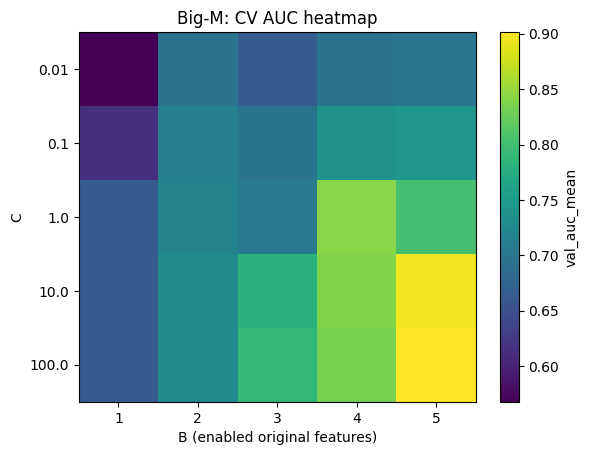

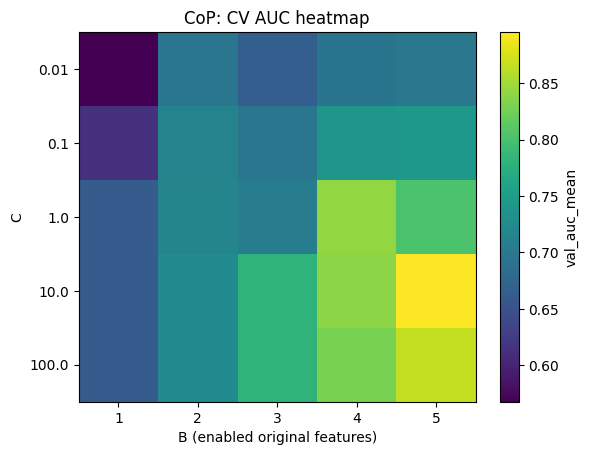

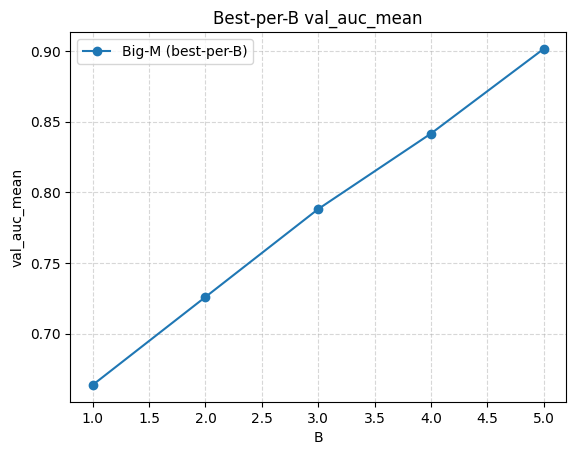

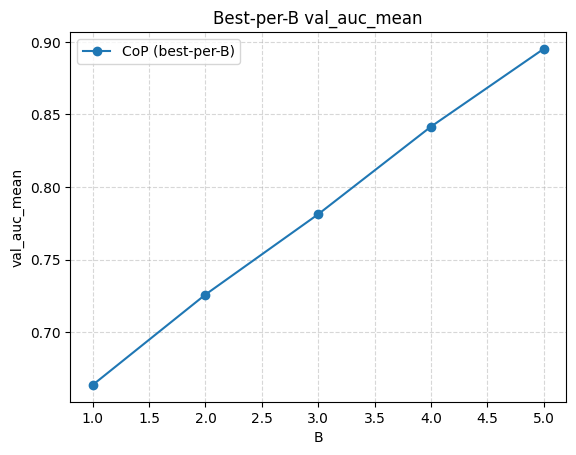

C:\Users\Snoopy\AppData\Local\Temp\ipykernel_15664\901617840.py:687: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


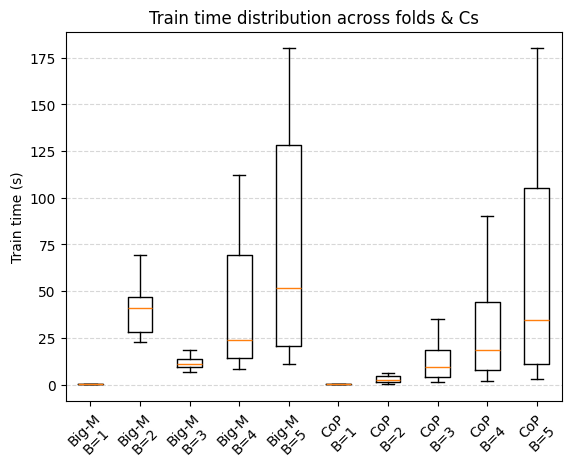

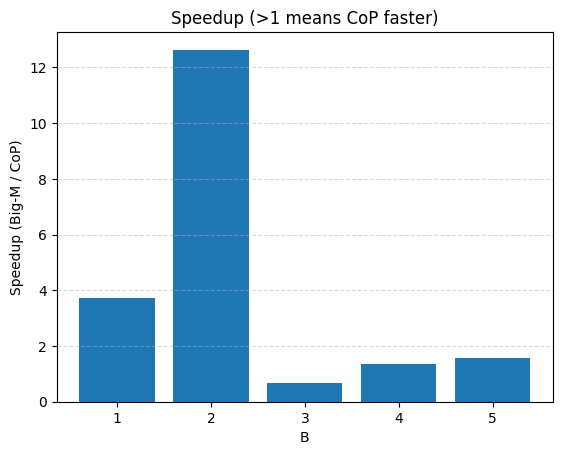

In [9]:
# 读取 UCI 数据
parkinsons = fetch_ucirepo(id=174) 

X_df = parkinsons.data.features
y_series = parkinsons.data.targets['status']

# 清洗与对齐
X_df = X_df.replace('?', np.nan).dropna()
y_series = y_series.loc[X_df.index]

feature_names = list(X_df.columns)
X_raw = X_df.values  # 不在这里标准化，让 CV 内处理

# 正确的标签编码（0/1 是整数）
y_int = pd.to_numeric(y_series, errors='raise').values
uniq = np.unique(y_int)
assert set(uniq) == {0, 1}, f"意外的类别：{uniq}"
y = np.where(y_int == 0, 1.0, -1.0)  # 0=+1, 1=-1

print(f"样本数量: {X_raw.shape[0]}, 特征数量: {X_raw.shape[1]}")
print("y 分布：", dict(zip(*np.unique(y, return_counts=True))))

# 网格
B_grid = list(range(1, 6))
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
gparams = dict(Seed=0, Heuristics=0.2, ConcurrentMIP=1)
K = 5

# 跑 CV（传原始 X；cv_grid 会自己做标准化）
df_bigm, agg_bigm = cv_grid_search_model(
    "Big-M", BigMNLSVMQuadPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=180.0, gurobi_params=gparams, warm_start=True, random_state=0
)

df_cop, agg_cop = cv_grid_search_model(
    "CoP", CoNLSVMQuad_NoMPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=180.0, gurobi_params=gparams, warm_start=True, random_state=0
)

# 合并挑最优（注意：修过的 merge_model_summaries 只按 B 合并）
agg_all = pd.concat([agg_bigm, agg_cop], ignore_index=True)
sum_bigm = pick_best_per_B(agg_all[agg_all["model"]=="Big-M"])
sum_cop  = pick_best_per_B(agg_all[agg_all["model"]=="CoP"])
merged   = merge_model_summaries(sum_bigm, sum_cop)

print("\n=== Best-per-B (Big-M) ===")
print(sum_bigm[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Best-per-B (CoP) ===")
print(sum_cop[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Big-M vs CoP (per-B) ===")
print(merged[["B","speedup_BigM_over_CoP","delta_auc_CoP_minus_BigM","delta_acc_CoP_minus_BigM",
              "train_time_mean_BigM","train_time_mean_CoP"]].to_string(index=False))

# 可视化
# --- 画图 ---
plot_heatmap(agg_all, "Big-M", metric="val_auc_mean", title="Big-M: CV AUC heatmap")
plot_heatmap(agg_all, "CoP",   metric="val_auc_mean", title="CoP: CV AUC heatmap")

plot_best_curve(sum_bigm, label="Big-M (best-per-B)", metric="val_auc_mean")
plot_best_curve(sum_cop,  label="CoP (best-per-B)",   metric="val_auc_mean")

plot_runtime_box(pd.concat([df_bigm, df_cop], ignore_index=True))

plot_speedup_bar(merged)


In [22]:
# fetch dataset 
ionosphere = fetch_ucirepo(id=52) 
# data (as pandas dataframes) 
X_iono = ionosphere.data.features 
y_iono = ionosphere.data.targets 
print(f"样本数量: {X_iono.shape[0]}")
print(f"特征数量: {X_iono.shape[1]}")
print(y_iono.head())

样本数量: 351
特征数量: 34
  Class
0     g
1     b
2     g
3     b
4     g


样本数量: 351, 特征数量: 34
y 分布： {np.float64(-1.0): np.int64(126), np.float64(1.0): np.int64(225)}
Set parameter Username
Set parameter LicenseID to value 2629579
Academic license - for non-commercial use only - expires 2026-02-28
[Big-M] progress: 1/125  (fold=1, B=1, C=0.01)  elapsed=2.0s
[Big-M] progress: 2/125  (fold=1, B=1, C=0.1)  elapsed=3.5s
[Big-M] progress: 3/125  (fold=1, B=1, C=1.0)  elapsed=5.2s
[Big-M] progress: 4/125  (fold=1, B=1, C=10.0)  elapsed=6.6s
[Big-M] progress: 5/125  (fold=1, B=1, C=100.0)  elapsed=8.0s
[Big-M] progress: 6/125  (fold=1, B=2, C=0.01)  elapsed=128.3s
[Big-M] progress: 7/125  (fold=1, B=2, C=0.1)  elapsed=248.4s
[Big-M] progress: 8/125  (fold=1, B=2, C=1.0)  elapsed=368.5s
[Big-M] progress: 9/125  (fold=1, B=2, C=10.0)  elapsed=488.6s
[Big-M] progress: 10/125  (fold=1, B=2, C=100.0)  elapsed=608.7s
[Big-M] progress: 11/125  (fold=1, B=3, C=0.01)  elapsed=729.1s
[Big-M] progress: 12/125  (fold=1, B=3, C=0.1)  elapsed=849.2s
[Big-M] progress: 13/125  (fol

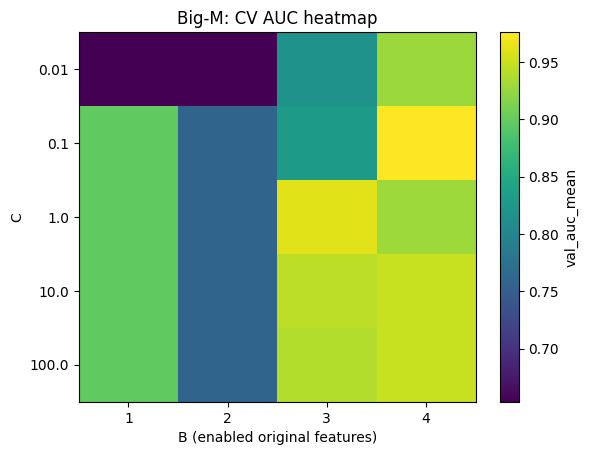

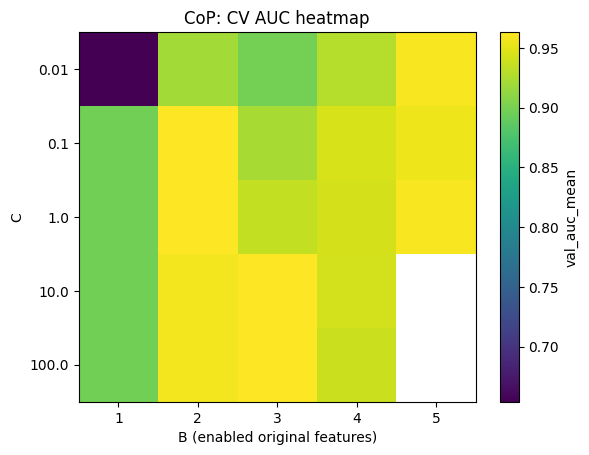

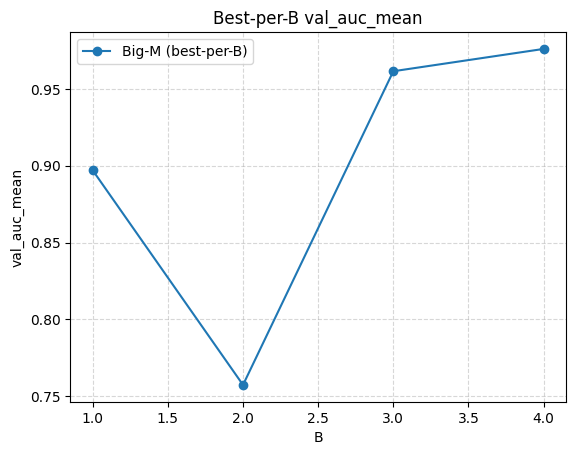

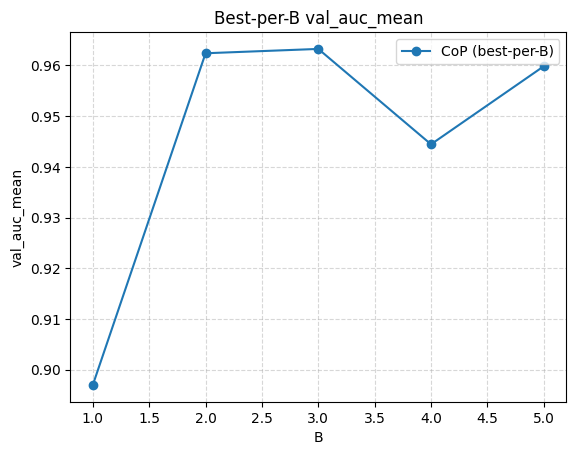

C:\Users\Snoopy\AppData\Local\Temp\ipykernel_9896\1029186281.py:758: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


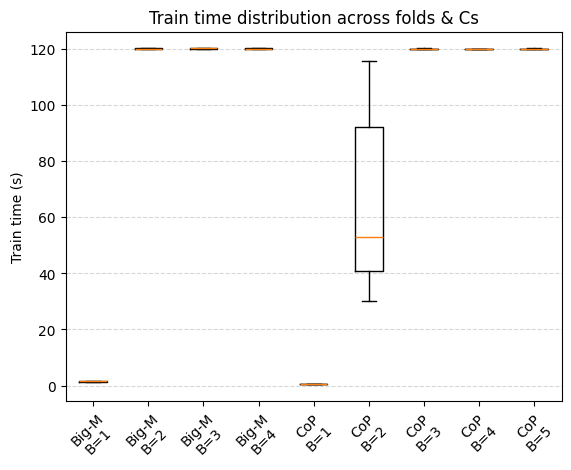

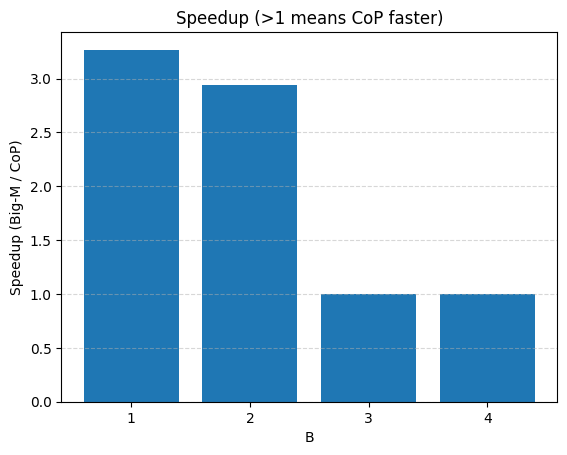

In [3]:
# 读取 UCI 数据
ionosphere = fetch_ucirepo(id=52)  
X_df = ionosphere.data.features
y_series = ionosphere.data.targets['Class']

# 清洗与对齐
X_df = X_df.replace('?', np.nan).dropna()
y_series = y_series.loc[X_df.index]

feature_names = list(X_df.columns)
X_raw = X_df.values  # 不在这里标准化，让 CV 内处理

# y_series: 形如包含 'N' / 'R' 的 pandas Series
y_str = y_series.astype(str).str.strip().str.upper().values

# 检查是否真的是二分类且只含 g/b
uniq = np.unique(y_str)
if not set(uniq).issubset({"G", "B"}) or len(uniq) != 2:
    raise ValueError(f"期望标签为 {{'G','B'}}，但实际唯一取值={uniq}")

# 约定：g -> +1，b -> -1  （和你之前的一致）
y = np.where(y_str == "G", 1.0, -1.0)

print(f"样本数量: {X_raw.shape[0]}, 特征数量: {X_raw.shape[1]}")
print("y 分布：", dict(zip(*np.unique(y, return_counts=True))))

# 网格
B_grid = list(range(1, 6))
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
gparams = dict(Seed=0, Heuristics=0.2, ConcurrentMIP=1)
K = 5

# 跑 CV(传原始 X；cv_grid 会自己做标准化)
gparams = dict(Seed=0, Threads=4, ConcurrentMIP=0, MIPGap=0.03)

df_bigm, agg_bigm = cv_grid_search_model(
    "Big-M", BigMNLSVMQuadPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=120.0, gurobi_params=gparams,
    warm_start=True, random_state=0,
    global_time_budget=1800,    # 整个 Big-M 最长 30 分钟
    progress=True
)

df_cop, agg_cop = cv_grid_search_model(
    "CoP", CoNLSVMQuad_NoMPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=120.0, gurobi_params=gparams, 
    warm_start=True, random_state=0,
    global_time_budget=1800,    # 整个 CoP 最长 30 分钟
    progress=True
)

# 合并挑最优（注意：修过的 merge_model_summaries 只按 B 合并）
agg_all = pd.concat([agg_bigm, agg_cop], ignore_index=True)
sum_bigm = pick_best_per_B(agg_all[agg_all["model"]=="Big-M"])
sum_cop  = pick_best_per_B(agg_all[agg_all["model"]=="CoP"])
merged   = merge_model_summaries(sum_bigm, sum_cop)

print("\n=== Best-per-B (Big-M) ===")
print(sum_bigm[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Best-per-B (CoP) ===")
print(sum_cop[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Big-M vs CoP (per-B) ===")
print(merged[["B","speedup_BigM_over_CoP","delta_auc_CoP_minus_BigM","delta_acc_CoP_minus_BigM",
              "train_time_mean_BigM","train_time_mean_CoP"]].to_string(index=False))

# 可视化
# --- 画图 ---
plot_heatmap(agg_all, "Big-M", metric="val_auc_mean", title="Big-M: CV AUC heatmap")
plot_heatmap(agg_all, "CoP",   metric="val_auc_mean", title="CoP: CV AUC heatmap")

plot_best_curve(sum_bigm, label="Big-M (best-per-B)", metric="val_auc_mean")
plot_best_curve(sum_cop,  label="CoP (best-per-B)",   metric="val_auc_mean")

plot_runtime_box(pd.concat([df_bigm, df_cop], ignore_index=True))

plot_speedup_bar(merged)


In [3]:
breast_cancer_wisconsin_prognostic = fetch_ucirepo(id=16) 
# data (as pandas dataframes) 
X_bcwp = breast_cancer_wisconsin_prognostic.data.features 
y_bcwp = breast_cancer_wisconsin_prognostic.data.targets['Outcome']
print(f"样本数量: {X_bcwp.shape[0]}")
print(f"特征数量: {X_bcwp.shape[1]}")
print(y_bcwp.head())

样本数量: 198
特征数量: 33
0    N
1    N
2    N
3    N
4    R
Name: Outcome, dtype: object


样本数量: 194, 特征数量: 33
y 分布： {np.float64(-1.0): np.int64(46), np.float64(1.0): np.int64(148)}
Set parameter Username
Set parameter LicenseID to value 2629579
Academic license - for non-commercial use only - expires 2026-02-28
[Big-M] progress: 1/125  (fold=1, B=1, C=0.01)  elapsed=1.1s
[Big-M] progress: 2/125  (fold=1, B=1, C=0.1)  elapsed=1.8s
[Big-M] progress: 3/125  (fold=1, B=1, C=1.0)  elapsed=2.7s
[Big-M] progress: 4/125  (fold=1, B=1, C=10.0)  elapsed=3.5s
[Big-M] progress: 5/125  (fold=1, B=1, C=100.0)  elapsed=4.3s
[Big-M] progress: 6/125  (fold=1, B=2, C=0.01)  elapsed=124.4s
[Big-M] progress: 7/125  (fold=1, B=2, C=0.1)  elapsed=244.4s
[Big-M] progress: 8/125  (fold=1, B=2, C=1.0)  elapsed=364.5s
[Big-M] progress: 9/125  (fold=1, B=2, C=10.0)  elapsed=484.5s
[Big-M] progress: 10/125  (fold=1, B=2, C=100.0)  elapsed=604.6s
[Big-M] progress: 11/125  (fold=1, B=3, C=0.01)  elapsed=662.8s
[Big-M] progress: 12/125  (fold=1, B=3, C=0.1)  elapsed=782.9s
[Big-M] progress: 13/125  (fold

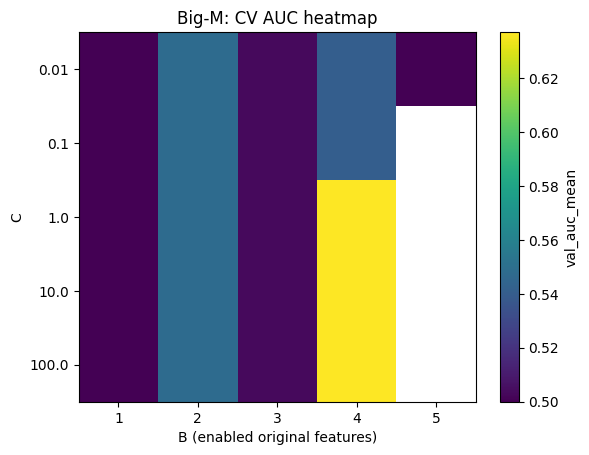

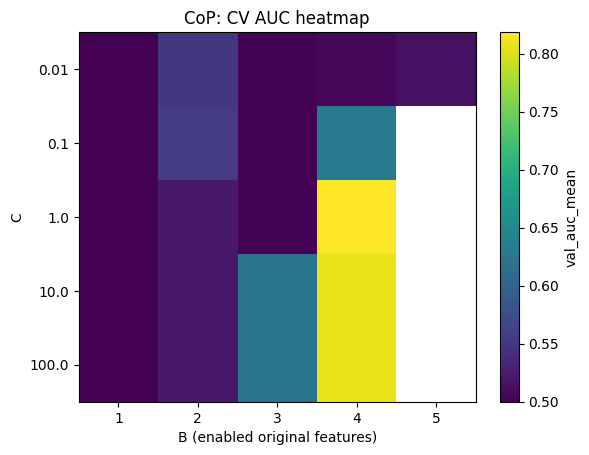

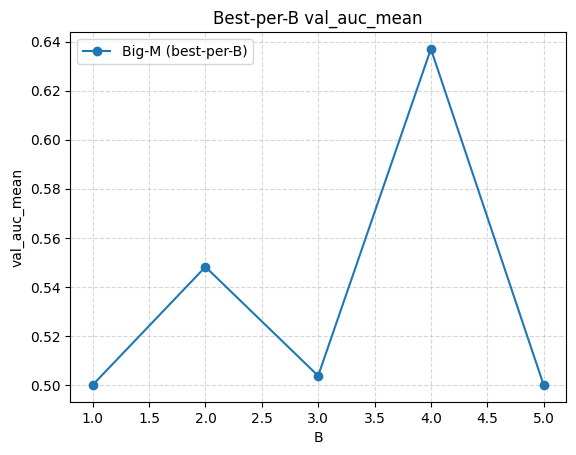

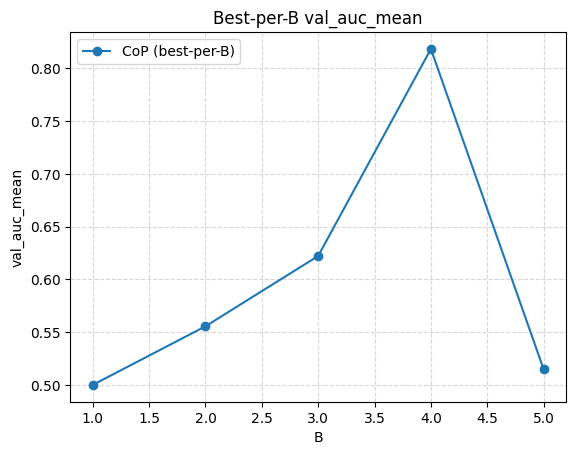

C:\Users\Snoopy\AppData\Local\Temp\ipykernel_20756\1029186281.py:758: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


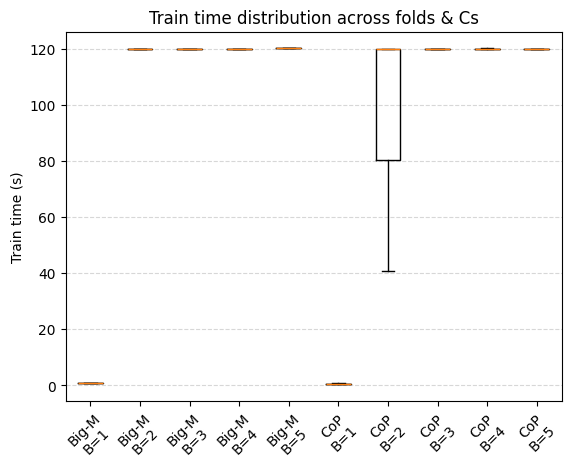

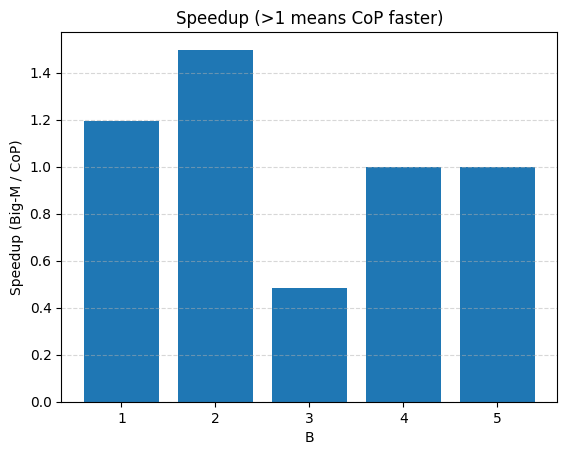

In [4]:
# 读取 UCI 数据
breast_cancer_wisconsin_prognostic = fetch_ucirepo(id=16) 
X_df = breast_cancer_wisconsin_prognostic.data.features
y_series = breast_cancer_wisconsin_prognostic.data.targets['Outcome']

# 清洗与对齐
X_df = X_df.replace('?', np.nan).dropna()
y_series = y_series.loc[X_df.index]

feature_names = list(X_df.columns)
X_raw = X_df.values  # 不在这里标准化，让 CV 内处理

# y_series: 形如包含 'N' / 'R' 的 pandas Series
y_str = y_series.astype(str).str.strip().str.upper().values

# 检查是否真的是二分类且只含 N/R
uniq = np.unique(y_str)
if not set(uniq).issubset({"N", "R"}) or len(uniq) != 2:
    raise ValueError(f"期望标签为 {{'N','R'}}，但实际唯一取值={uniq}")

# 约定：N -> +1，R -> -1  （和你之前的一致）
y = np.where(y_str == "N", 1.0, -1.0)

print(f"样本数量: {X_raw.shape[0]}, 特征数量: {X_raw.shape[1]}")
print("y 分布：", dict(zip(*np.unique(y, return_counts=True))))

# 网格
B_grid = list(range(1, 6))
C_grid = [0.01, 0.1, 1.0, 10.0, 100.0]
gparams = dict(Seed=0, Heuristics=0.2, ConcurrentMIP=1)
K = 5

# 跑 CV(传原始 X；cv_grid 会自己做标准化)
gparams = dict(Seed=0, Threads=4, ConcurrentMIP=0, MIPGap=0.03)

df_bigm, agg_bigm = cv_grid_search_model(
    "Big-M", BigMNLSVMQuadPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=120.0, gurobi_params=gparams,
    warm_start=True, random_state=0,
    global_time_budget=1800,    # 整个 Big-M 最长 30 分钟
    progress=True
)

df_cop, agg_cop = cv_grid_search_model(
    "CoP", CoNLSVMQuad_NoMPlus, X_raw, y, feature_names,
    B_grid=B_grid, C_grid=C_grid,
    n_splits=K, time_limit=120.0, gurobi_params=gparams, 
    warm_start=True, random_state=0,
    global_time_budget=1800,    # 整个 CoP 最长 30 分钟
    progress=True
)

# 合并挑最优（注意：修过的 merge_model_summaries 只按 B 合并）
agg_all = pd.concat([agg_bigm, agg_cop], ignore_index=True)
sum_bigm = pick_best_per_B(agg_all[agg_all["model"]=="Big-M"])
sum_cop  = pick_best_per_B(agg_all[agg_all["model"]=="CoP"])
merged   = merge_model_summaries(sum_bigm, sum_cop)

print("\n=== Best-per-B (Big-M) ===")
print(sum_bigm[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Best-per-B (CoP) ===")
print(sum_cop[["B","C","val_auc_mean","val_acc_mean","train_time_mean","train_gap_mean"]].to_string(index=False))
print("\n=== Big-M vs CoP (per-B) ===")
print(merged[["B","speedup_BigM_over_CoP","delta_auc_CoP_minus_BigM","delta_acc_CoP_minus_BigM",
              "train_time_mean_BigM","train_time_mean_CoP"]].to_string(index=False))

# 可视化
# --- 画图 ---
plot_heatmap(agg_all, "Big-M", metric="val_auc_mean", title="Big-M: CV AUC heatmap")
plot_heatmap(agg_all, "CoP",   metric="val_auc_mean", title="CoP: CV AUC heatmap")

plot_best_curve(sum_bigm, label="Big-M (best-per-B)", metric="val_auc_mean")
plot_best_curve(sum_cop,  label="CoP (best-per-B)",   metric="val_auc_mean")

plot_runtime_box(pd.concat([df_bigm, df_cop], ignore_index=True))

plot_speedup_bar(merged)